In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [2]:
tf.keras.backend.set_floatx('float32')

In [3]:
x, y = load_digits(return_X_y=True)
x.shape, y.shape, set(y)

((1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

학습 데이터와 테스트 데이터를 나눕니다.

In [4]:
m = len(y)//2
x_train = x[:m]
y_train = y[:m]
x_test = x[m:m*2]
y_test = y[m:m*2]
x_test.shape, y_test.shape

((898, 64), (898,))

In [5]:
def convert_2_num(x_test, y_test):
    x_test = np.reshape(x_test, [-1, 8, 8])
    x_test_l, x_test_r = np.split(x_test, 2, axis=0) 
    x_test_lr = np.concatenate((x_test_l, x_test_r), axis=2)
    y_test_l, y_test_r = np.split(y_test, 2, axis=0) 
    y_test = np.stack((y_test_l, y_test_r), -1)

    #우측에 비어있는 이미지를 붙여서 한자리수 데이터를 만듭니다
    BLANK = 10 #'없음' 을 나타내는 기호
    x_test_blank = np.concatenate((x_test_l, np.zeros_like(x_test_r)), axis=2)
    y_test_blank = np.stack((y_test_l, np.zeros_like(y_test_l) + BLANK), 1)#좌측 영상의 y와 빈 영상의 y를 통합

    #두자리수 데이터와 한자리수 데이터를 통합합니다
    x_test_set = np.concatenate((x_test_lr, x_test_blank), 0)# 두자리수 영상과 한자리수 영상을 통합
    y_test_set = np.concatenate((y_test, y_test_blank), 0)#두자리수 y와 한자리수 y 를 통합
    return x_test_set,  y_test_set

In [6]:
x_test_set,  y_test_set = convert_2_num(x_test, y_test)
x_train_set,  y_train_set = convert_2_num(x_train, y_train)

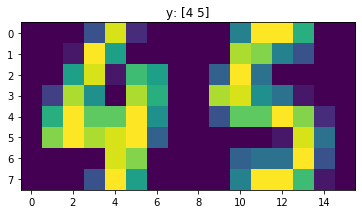

In [7]:
i = 11
plt.title('y: '+str(y_test_set[i]))
plt.imshow(x_test_set[i].reshape((8,-1)))

In [22]:
class MyModel(keras.Model):
    def __init__(self):    
        super(MyModel, self).__init__()
        self.k = 10+1 # 클래스 갯수 
        self.seq = 2 # 자릿수
        self.opt = tf.optimizers.Nadam(learning_rate=0.01)#Stochatic Gradient Descent 확률적 경사 하강
        self.conv0 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.elu)
        self.conv1 = keras.layers.Conv2D(32, [3,3], padding='same', activation=keras.activations.elu)
        self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
        self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')    
        self.lstm = keras.layers.LSTM(units=self.k, return_sequences=True)
        self.rnn = keras.layers.RNN(cell=self.k, return_sequences=True)
        self.GRU = keras.layers.GRU(units=self.k, return_sequences=True)
    
    def call(self, x):
        #x (1797, 64)
        x_4d = tf.reshape(x, [-1,8,8*2,1]) 
        x_4d = tf.cast(x_4d, tf.float32)
        net = self.conv0(x_4d)
        net = self.pool0(net)#(4,8,16)
        net = self.conv1(net)
        net = self.pool1(net)#(2,4,32)
#         net = self.pool1(net)#(1,2,32)
#         net = tf.squeeze(net, axis=1)#(2,32)
        net = tf.reduce_sum(net, axis=1) # (4,32) 4개의 시퀀스
        h = self.lstm(net)#(2,10)        # 4개의 output
        h = h[:,2:] # 앞에 2개의 output은 버리고 뒤의 2개의 output만 사용
        h = tf.nn.softmax(h, axis=2)
        return h

    def get_loss(self, y, h):
        #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
        h = tf.clip_by_value(h, 1e-8, 1 - 1e-8) # h 가 0이나 1이 되지 않도록 하는 안전장치 
        cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
        loss = tf.reduce_mean(cross_entropy)
        return loss

    def get_accuracy(self, y, h):    
        predict = tf.argmax(h, -1)
        is_equal = tf.equal(y, predict)
        self.acc = tf.reduce_mean(tf.cast(is_equal, tf.float32)) # True > 1, False > 0 로 cast
        self.acc_all = tf.reduce_mean(tf.cast(tf.reduce_all(is_equal, axis=1), tf.float32))

    def fit(self, x, y, epoch=1):
        # x : (m, 8, 16), y: (m, 2)    
        y_hot = tf.one_hot(y, depth=self.k, axis=-1)#(m, 2, 10)  
        for i in range(epoch):
            with tf.GradientTape() as tape: #경사 기록 장치
                h = self.call(x)
                loss = self.get_loss(y_hot, h)        
            grads = tape.gradient(loss, self.trainable_variables) #경사 계산
            #경사가 너무 크면 nan 이 될 수 있으므로 gradient cliping (최소,최대값 제한) 을 합니다
            grads = [(tf.clip_by_value(grad, -5.0, 5.0)) for grad in grads]      
            self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
            self.get_accuracy(y, h)
            if i%10==0:
                print('%d/%d loss:%.3f acc:%.3f acc_all:%.3f'%(i, epoch, loss, self.acc, self.acc_all))
model = MyModel()

SyntaxError: invalid syntax (<ipython-input-22-d30f940e8560>, line 6)

In [23]:
model.fit(x_train_set, y_train_set, epoch=100) #학습

0/100 loss:0.240 acc:0.357 acc_all:0.098
10/100 loss:0.239 acc:0.425 acc_all:0.171
20/100 loss:0.234 acc:0.403 acc_all:0.143
30/100 loss:0.220 acc:0.404 acc_all:0.130
40/100 loss:0.220 acc:0.452 acc_all:0.157
50/100 loss:0.208 acc:0.404 acc_all:0.127
60/100 loss:0.208 acc:0.418 acc_all:0.140
70/100 loss:0.204 acc:0.427 acc_all:0.148
80/100 loss:0.206 acc:0.420 acc_all:0.145
90/100 loss:0.203 acc:0.429 acc_all:0.147


In [24]:
# 테스트셋의 성능
h = model(x_test_set)
model.get_accuracy(y_test_set, h)
print('개별정확도',model.acc.numpy(),'두자리 모두 맞춘 정확도', model.acc_all.numpy())

개별정확도 0.39198217 두자리 모두 맞춘 정확도 0.1325167
